In [ ]:
%%capture
!pip install lightning
!pip install torchgeo

In [ ]:
%matplotlib inline
%load_ext tensorboard

import os
import tempfile

import torch
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from torchgeo.models import ResNet18_Weights,ResNet50_Weights
from torchgeo.trainers import ClassificationTask
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import timm
from torchgeo.datasets import RasterDataset, stack_samples
from torchgeo.samplers import RandomBatchGeoSampler, RandomGeoSampler
from torch.utils.data import DataLoader
import lightning as pl
import os
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassJaccardIndex
from segmentation_models_pytorch.losses import FocalLoss, JaccardLoss
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassFBetaScore,
    MulticlassJaccardIndex,
    MultilabelAccuracy,
    MultilabelFBetaScore,
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, input_channels, num_filters):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels=input_channels, out_channels=num_filters, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels=num_filters*2, num_filters=num_filters)  # *2 for concatenation
        self.conv_block1 = ConvBlock(in_channels=num_filters, num_filters=num_filters)  # *2 for concatenation

    def forward(self, x, skip_features=None):
        x = self.upconv(x)
        if skip_features is not None:
          x = torch.cat([x, skip_features], dim=1)
          x = self.conv_block(x)
        x = self.conv_block1(x)
        return x

class center(nn.Module):
  """
  This is the middle layer of the UNet which just consists of some
  """

  def __init__(self, in_channels, out_channels):
      super().__init__()
      self.bridge = nn.Sequential(
          ConvBlock(in_channels, out_channels),
          ConvBlock(out_channels, out_channels)
      )

  def forward(self, x):
      return self.bridge(x)


In [ ]:
class UnetResnetSentinel2(nn.Module):
  def __init__(self, input_channels,num_classes):
    super().__init__()
    self.weights = ResNet50_Weights.SENTINEL2_ALL_MOCO
    model = ClassificationTask(
        model='resnet50',
        weights=self.weights,
        in_channels=input_channels,
        num_classes=num_classes,
    )

    """Freeze the encoder weights"""
    for i in model.parameters():
      i.requires_grad = False

    """Input layer"""
    self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

    """Encoder"""
    self.e1 =  list(model.children())[0].layer1
    self.e2 =  list(model.children())[0].layer2
    self.e3 =  list(model.children())[0].layer3

    """Bottleneck"""
    self.center =  list(model.children())[0].layer4

    """Decoder"""
    self.d1 = DecoderBlock(2048,1024)
    self.d2 = DecoderBlock(1024,512)
    self.d3 = DecoderBlock(512,256)
    self.d4 = DecoderBlock(256,64)
    self.d5 = DecoderBlock(64,64)

    """Final layer"""
    self.final = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1),
      nn.Softmax(dim=1)
      )

  def forward(self,x):
    x = self.relu(self.bn1(self.conv1(x)))
    x_ = self.maxpool(x)
    e1 = self.e1(x_)
    e2 = self.e2(e1)
    e3 = self.e3(e2)
    center = self.center(e3)
    d1 = self.d1(center,e3)
    d2 = self.d2(d1,e2)
    d3 = self.d3(d2,e1)
    d4 = self.d4(d3,x)
    d5 = self.d5(d4)
    final = self.final(d5)
    return final

In [ ]:
class unet(pl.LightningModule):
    def __init__(self, encoder,nc,c,loss):
        super(unet,self).__init__()
        self.encoder = encoder(nc,c)
        self.loss = loss
        self.classes = c

    # def configure_losses(self) -> None:
    #     """Initialize the loss criterion.

    #     Raises:
    #         ValueError: If *loss* is invalid.
    #     """
        loss: str = self.loss
        if loss == 'ce':
            self.criterion: nn.Module = nn.CrossEntropyLoss(
            )
        elif loss == 'bce':
            self.criterion = nn.BCEWithLogitsLoss()
        elif loss == 'jaccard':
            self.criterion = JaccardLoss(mode='multiclass')
        elif loss == 'focal':
            self.criterion = FocalLoss(mode='multiclass', normalized=True)
        else:
            raise ValueError(f"Loss type '{loss}' is not valid.")

    # def configure_metrics(self) -> None:
        metrics = MetricCollection(
            {
                'OverallAccuracy': MulticlassAccuracy(
                    num_classes=self.classes, average='micro'
                ),
                'AverageAccuracy': MulticlassAccuracy(
                    num_classes=self.classes, average='macro'
                ),
                'JaccardIndex': MulticlassJaccardIndex(
                    num_classes=self.classes
                ),
                'F1Score': MulticlassFBetaScore(
                    num_classes=self.classes, beta=1.0, average='micro'
                ),
            }
        )
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')


    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x = batch
        x_hat = self.encoder(x['image'])
        # y = torch.nn.functional.one_hot(x['mask'], num_classes=self.classes).permute(0,3,1,2).float()
        y = x['mask']
        loss: torch.Tensor = self.criterion(x_hat, y)
        self.train_metrics(x_hat, y)
        values = {"loss": loss}
        self.log_dict(values,prog_bar=True)
        self.log_dict(self.train_metrics,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx)-> None:
        x = batch
        x_hat = self.encoder(x['image'])
        # y = torch.nn.functional.one_hot(x['mask'], num_classes=self.classes).permute(0,3,1,2).float()
        y = x['mask']
        loss = self.criterion(x_hat, y)
        self.val_metrics(x_hat, y)
        values = {"vall_loss": loss}
        self.log_dict(values,prog_bar=True)
        self.log_dict(self.val_metrics,prog_bar=True)
        return loss

    # def test_step(self, batch, batch_idx)-> None:
    #     # this is the test loop
    #     x = batch
    #     x_hat = self.encoder(x['image'])
    #     y = torch.nn.functional.one_hot(x['mask'], num_classes=self.classes).permute(0,3,1,2).float()
    #     loss: Tensor = self.criterion(x_hat, y)
    #     miou = self.miou(x_hat, y)
    #     values = {"test_loss": loss, "test_Iou": miou}
    #     self.log_dict(values,prog_bar=True)
    #     return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
def preprocess(sample):
    if "image" in sample:
        sample["image"] = (sample["image"] / 10000.0).float()  # inputs are normalized to [0, 1]
    if "mask" in sample:
        sample["mask"] = sample["mask"].squeeze().long()
    del sample["crs"]
    del sample["bounds"]
    return sample

class SegmentationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        image_fn_root,
        mask_fn_root,
        batch_size=64,
        patch_size=256,
        num_workers=6,
        train_batches_per_epoch=300,
        val_batches_per_epoch=32,
    ):
        super().__init__()
        self.image_fn_root = image_fn_root
        self.mask_fn_root = mask_fn_root
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.train_batches_per_epoch = train_batches_per_epoch
        self.val_batches_per_epoch = val_batches_per_epoch
        self.filename_regex = '*.tif'
    # def setup(self, stage=None):
        self.image_ds = RasterDataset(
            self.image_fn_root,
            transforms=preprocess,

        )

        self.mask_ds = RasterDataset(
            self.mask_fn_root,
            transforms=preprocess,
            # self.filename_regex = '*.tif'
        )
        self.mask_ds.is_image = False

        self.ds = self.image_ds & self.mask_ds

    def train_dataloader(self):
        sampler = RandomBatchGeoSampler(
            self.ds, size=self.patch_size, batch_size=self.batch_size, length=self.train_batches_per_epoch * self.batch_size
        )

        return DataLoader(
            self.ds,
            batch_sampler=sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples
        )

    def val_dataloader(self):
        sampler = RandomBatchGeoSampler(
            self.ds, size=self.patch_size, batch_size=self.batch_size, length=self.val_batches_per_epoch * self.batch_size
        )

        return DataLoader(
            self.ds,
            batch_sampler=sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples
        )

In [ ]:
datamodule = SegmentationDataModule(
    "/content/drive/MyDrive/Arecanut area estimate/image/",
    "/content/drive/MyDrive/Arecanut area estimate/Data/rasterized_gubi_lulc1.tif",
    batch_size=10,
    num_workers=2,
    patch_size=64,
    train_batches_per_epoch=100,
    val_batches_per_epoch=10,
)

In [ ]:
# encoder = UnetResnetSentinel2(11,15)
model = unet(UnetResnetSentinel2,11,15,'jaccard')

In [ ]:
early_stop_callback = EarlyStopping(monitor="train_JaccardIndex", min_delta=0.00, patience=3, verbose=False, mode="max")

In [ ]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=10,
    monitor="train_JaccardIndex",
    mode="max",
    dirpath="/content/drive/MyDrive/Arecanut area estimate/models/",
    filename="arecanut-unetresnetsent2-128-{epoch:02d}-{train_JaccardIndex}",
    save_last=True,
)

In [ ]:
trainer = pl.Trainer(accelerator='cpu', max_epochs=5, profiler="advanced",callbacks = [checkpoint_callback,early_stop_callback])

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=model, train_dataloaders=datamodule)

INFO: 
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | encoder       | UnetResnetSentinel2 | 97.0 M | train
1 | criterion     | JaccardLoss         | 0      | train
2 | train_metrics | MetricCollection    | 0      | train
3 | val_metrics   | MetricCollection    | 0      | train
4 | test_metrics  | MetricCollection    | 0      | train
--------------------------------------------------------------
73.5 M    Trainable params
23.5 M    Non-trainable params
97.0 M    Total params
387.805   Total estimated model params size (MB)
292       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | encoder       | UnetResnetSentinel2 | 97.0 M | train
1 | criterion     | JaccardLoss         | 0      | train
2 | train_metrics | MetricCollection    | 0      |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for i in datamodule.train_dataloader():
  break

In [ ]:
i['image'].shape

torch.Size([10, 3, 64, 64])

In [ ]:
torch.nn.functional.one_hot(i['mask'], num_classes=15).shape

torch.Size([10, 64, 64, 15])

In [ ]:
i['mask'].shape

torch.Size([10, 64, 64])

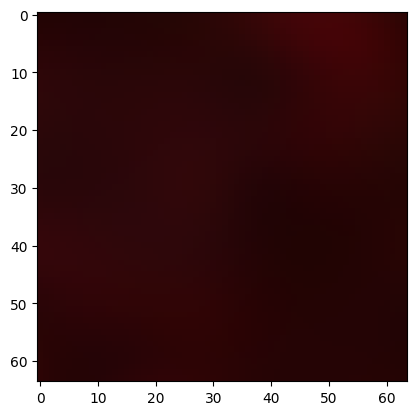

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(i['image'][3].permute(1,2,0)[:,:,0:3])

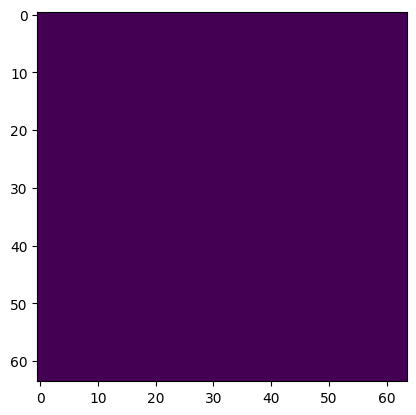

In [ ]:
plt.imshow(i['mask'][3])

In [ ]:
i.keys()

dict_keys(['image', 'mask'])